In [17]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [18]:
%matplotlib inline

# Loading the Datasets

In [19]:
hp_train = pd.read_csv('data/train.csv')

In [20]:
hp_test = pd.read_csv('data/test.csv')

In [21]:
combined = (hp_train, hp_test)

In [ ]:
hp_train.head()

In [ ]:
hp_train.info()

In [ ]:
hp_test.head()

In [ ]:
hp_test.info()

In [16]:
nacols = pd.concat(combined, sort=False).drop('SalePrice', axis=1).isna().sum()
nacols[nacols > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

# Preprocessing

## Removing outliers

The documentation for the dataset recommends dropping 5 outliers from it, they are all characterized by having GrLivArea > 4000.

In [59]:
hp_train.drop(hp_train[(hp_train.GrLivArea > 4000)].index, inplace=True)

## Using log of SalePrice

[Gehsbargs](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force/notebook) suggests, with a quite reasonable argument, that the log of the original target variable should be used as our target.

In [60]:
hp_train['LogSP'] = hp_train.SalePrice.apply(lambda x: np.log(x + 1))

## Filling missing categorical data

Later it might pay to replace this arbitrary labelling with something like KNN

In [61]:
def fill_cat_na (col, fill_val='UKN'):
    if col.isna().sum() > 0 and col.dtype.name == 'object':
        return col.fillna(fill_val)
    return col

In [65]:
hp_train = hp_train.apply(fill_cat_na)
hp_test = hp_test.apply(fill_cat_na)
combined = (hp_train, hp_test)

## Reencoding categorical data

In [66]:
def gen_fit_les (data):
    """
    Generates a dictionary of LabelEncoders with an entry
    for each column in data that is of type object
    """
    
    cat_cols_les = {x: LabelEncoder() \
                    for x in data if data[x].dtype.name == 'object'}

    for item in cat_cols_les.items():
        col = item[0]
        le = item[1]
        le.fit(data[col])
        
    return cat_cols_les

def les_transform (data, le_dict):
    """
    Transforms data's columns with a dictionary generated by
    gen_fit_les (above)
    """
    
    for item in le_dict.items():
        col = item[0]
        le = item[1]
        data[col] = le.transform(data[col])
        
def les_inverse_transform (data, le_dict):
    """
    Inverse transforms data's columns with a dictionary generated by
    gen_fit_les (above)
    """
    
    for item in le_dict.items():
        col = item[0]
        le = item[1]
        
        data[col] = le.inverse_transform(data[col])

In [67]:
cat_cols_les = gen_fit_les(pd.concat(combined, sort=False))
les_transform(hp_train, cat_cols_les)
les_transform(hp_test, cat_cols_les)

# Random Forest Model

In [28]:
nacols = pd.concat(combined, sort=False).isna().sum()
nacols = list(nacols[nacols > 0].index)

In [71]:
excluded_features = ['SalePrice', 'LogSP', 'Id']

In [72]:
used_features = [x for x in hp_test.columns \
                 if x not in nacols + excluded_features]

In [159]:
used_features = ['OverallQual',
                 'GrLivArea',
                 '1stFlrSF',
                 '2ndFlrSF',
                 'LotArea',
                 'YearBuilt',
                 'Neighborhood',
                 'YearRemodAdd',
                 'GarageType'
                ]

In [148]:
train, test = train_test_split(hp_train[used_features + ['LogSP', 'SalePrice']],
                               test_size=0.3)

In [149]:
model = RandomForestRegressor()
model.fit(train[used_features], train['LogSP'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [150]:
scores = cross_val_score(RandomForestRegressor(),
                         hp_train[used_features],
                         hp_train['LogSP'],
                         scoring='neg_mean_absolute_error'
                        )

In [151]:
print("CV score: ({:.2f} +- {:.2f})e-1".format(scores.mean() * 10, scores.std() * 10))

CV score: (-1.17 +- 0.02)e-1


In [132]:
pred = model.predict(test[used_features]);

In [133]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [134]:
mean_absolute_error(test['SalePrice'], np.exp(pred) - 1)

21336.32093649723

In [136]:
mean_squared_log_error(test['SalePrice'], np.exp(pred) - 1)

0.02557924488801257

# Final model & submission

In [408]:
model_pred = DecisionTreeRegressor()
model_pred.fit(hp_train[used_features], hp_train['SalePrice'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [409]:
predictions = model_pred.predict(hp_test[used_features])

In [410]:
results = pd.DataFrame(hp_test['Id'])
results['SalePrice'] = predictions
results.to_csv('predictions.csv', 
               columns=('Id', 'SalePrice'), index=False)

# Experiments

Below this everything is permanently shifting and unstable

In [153]:
feature_importances = [*zip(used_features, model.feature_importances_)]
feature_importances

[('OverallQual', 0.5788592864504551),
 ('GrLivArea', 0.15141658911692923),
 ('1stFlrSF', 0.08036940668816973),
 ('2ndFlrSF', 0.011345847224837538),
 ('LotArea', 0.04565193954212459),
 ('YearBuilt', 0.04435087608465549),
 ('Neighborhood', 0.020922515237338693),
 ('YearRemodAdd', 0.03312309623627638),
 ('GarageType', 0.0339604434192132)]

In [42]:
from operator import itemgetter

In [120]:
sorted_features = sorted(feat_importances, key=itemgetter(1))[::-1][0:9]
sorted_features

[('OverallQual', 0.5507724013068596),
 ('GrLivArea', 0.1360465994715698),
 ('1stFlrSF', 0.05859076406713187),
 ('2ndFlrSF', 0.04575728131162006),
 ('LotArea', 0.04218683911271157),
 ('YearBuilt', 0.022547681346372455),
 ('Neighborhood', 0.014240992167284328),
 ('YearRemodAdd', 0.013076231325186427),
 ('GarageType', 0.012142020668977712)]

In [142]:
used_features = ['OverallQual',
                 'GrLivArea',
                 '1stFlrSF',
                 '2ndFlrSF',
                 'LotArea',
                 'YearBuilt',
                 'Neighborhood',
                 'YearRemodAdd',
                 'GarageType',
                 'HouseStyle'
                ]

In [123]:
sorted(feat_importances, key=itemgetter(1))[::-1]

[('OverallQual', 0.5507724013068596),
 ('GrLivArea', 0.1360465994715698),
 ('1stFlrSF', 0.05859076406713187),
 ('2ndFlrSF', 0.04575728131162006),
 ('LotArea', 0.04218683911271157),
 ('YearBuilt', 0.022547681346372455),
 ('Neighborhood', 0.014240992167284328),
 ('YearRemodAdd', 0.013076231325186427),
 ('GarageType', 0.012142020668977712),
 ('OpenPorchSF', 0.0084664039316899),
 ('TotRmsAbvGrd', 0.006398929646811093),
 ('OverallCond', 0.005662343727549199),
 ('KitchenQual', 0.004830257324840474),
 ('BsmtQual', 0.004599731994484424),
 ('PoolQC', 0.004446712718226651),
 ('BsmtFinType1', 0.004337622382934376),
 ('GarageFinish', 0.0039273229140841855),
 ('MSSubClass', 0.00385728334710671),
 ('BsmtExposure', 0.003663561873854479),
 ('WoodDeckSF', 0.0036146549647062534),
 ('Exterior2nd', 0.003522517609834388),
 ('CentralAir', 0.0028142438986087813),
 ('YrSold', 0.0026812341884567023),
 ('Exterior1st', 0.002623437986318856),
 ('BedroomAbvGr', 0.002623267326503735),
 ('MoSold', 0.0026016578384532

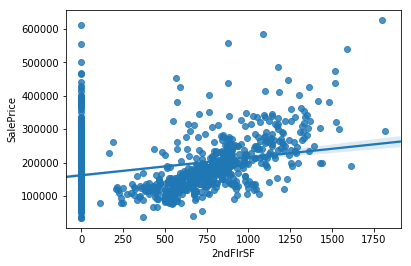

In [124]:
sns.regplot('2ndFlrSF', 'SalePrice', data=hp_train)

In [155]:
les_inverse_transform(hp_train, cat_cols_les)

In [157]:
les_transform(hp_train, cat_cols_les)

## Testing models

In [158]:
def model_tester (model, data, features1, features2, target, 
                  tt_split=0.3, n_reps=10):
    scores1 = []
    scores2 = []
    
    print('Evaluating models')
    for i in range(n_tries):
        train, test = train_test_split(data,
                                       test_size=0.3
                                      )
        
        model.fit(train[features1], train[target])
        pred1 = model.predict(test[features1])
        scores1.append(mean_absolute_error(test[target], pred1))
        
        model.fit(train[features2], train[target])
        pred2 = model.predict(test[features2])
        scores2.append(mean_absolute_error(test[target], pred2))
        
    print('Results:')
    print('Model 1: {:.2f} +- {:.2f}'\
          .format(scores1.mean(), scores1.std())
         )
    print('Model 2: {:.2f} +- {:.2f}'\
          .format(scores2.mean(), scores2.std())
         )

In [ ]:
model_tester(RandomForestRegressor(),
             hp_train,
             used_features,
             used_features + ['HouseStyle'],
             'SalePrice'
            )